In [11]:
import os
import gdcm
import pydicom
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt

from dicom2stl.examples import gui
from dicom2stl.utils import vtkutils
from dicom2stl.examples.myshow import myshow, myshow3d

from pydicom import dcmread
from pydicom.data import get_testdata_file
from pydicom.uid import ExplicitVRLittleEndian

from skimage import feature, filters
from skimage.filters import roberts, sobel, scharr, prewitt

import itkwidgets

%load_ext autoreload
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
%matplotlib notebook

## Original Images

In [13]:
path = "pos_twist_05iso_37"

In [14]:
reader = sitk.ImageSeriesReader()
dicom_names = reader.GetGDCMSeriesFileNames(path)
reader.SetFileNames(dicom_names)
image = reader.Execute()

size = image.GetSize()
size

(192, 512, 120)

<IPython.core.display.Javascript object>


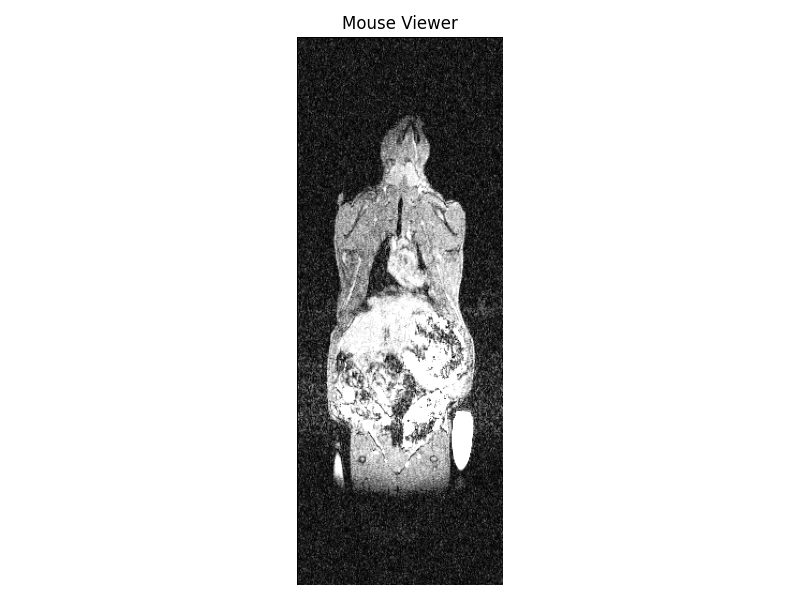

In [15]:
gui.MultiImageDisplay(image_list=[image], title_list=['Mouse Viewer'], figure_size=(8,6))

In [16]:
sitk.WriteImage(image, "mouse.nii.gz")

In [17]:
#Set limits to x and y for a good view
mouse = sitk.ReadImage("mouse.nii.gz")
itkwidgets.view(mouse)

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageUS3; pr…

In [18]:
!python dicom2stl/dicom2stl.py -i 90 -o mouse.stl mouse.nii.gz


Temp dir: Not specified, will use system temporary directory
Isovalue =  90.0
File names:  ['mouse.nii.gz'] 

Shrink factors:  [1, 2, 1]
(192, 512, 120) -> (192, 256, 120)
     0.012 seconds
Surface extracted
     1236596 polygons
     0.299 seconds
Surface cleaned
     1236596 polygons
     0.53 seconds
Small parts cleaned
     735408 polygons
     0.934 seconds
Surface smoothed
     735408 polygons
     2.842 seconds
Surface reduced
     73540 polygons
     6.987 seconds
Writing 73540 polygons to mouse.stl
writeSTL 1
Output mesh: mouse.stl



In [19]:
mesh = vtkutils.readMesh('mouse.stl')
itkwidgets.view(mesh, geometries=[mesh])

Input mesh: mouse.stl


Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [20]:
!python dicom2stl/dicom2stl.py --help

usage: dicom2stl.py [-h] [--verbose] [--debug] [--output OUTPUT] [--meta META]
                    [--ct] [--clean] [--temp TEMP] [--search SEARCH]
                    [--type {skin,bone,soft_tissue,fat}] [--anisotropic]
                    [--isovalue ISOVALUE] [--double DOUBLE_THRESHOLD]
                    [--largest] [--rotaxis {X,Y,Z}] [--rotangle ROTANGLE]
                    [--smooth SMOOTH] [--reduce REDUCE] [--clean-small SMALL]
                    [--enable {anisotropic,shrink,median,largest,rotation}]
                    [--disable {anisotropic,shrink,median,largest,rotation}]
                    [filenames [filenames ...]]

positional arguments:
  filenames

optional arguments:
  -h, --help            show this help message and exit
  --verbose, -v         Enable verbose messages
  --debug, -D           Enable debugging messages
  --output OUTPUT, -o OUTPUT
                        Output file name (default=result.stl)
  --meta META, -m META  Output metadata file
  --ct    

In [21]:
!python dicom2stl/dicom2stl.py -a -i 90 -t soft_tissue -l --smooth 100 --reduce 0.6 -x 0.1 -o mouse_2.stl mouse.nii.gz


Temp dir: Not specified, will use system temporary directory
Tissue type:  soft_tissue
Isovalue =  90.0
File names:  ['mouse.nii.gz'] 

Shrink factors:  [1, 2, 1]
(192, 512, 120) -> (192, 256, 120)
     0.012 seconds
Anisotropic Smoothing
     4.643 seconds
Median filter
     -14.056000000000001 seconds
Surface extracted
     216240 polygons
     0.154 seconds
Surface cleaned
     204186 polygons
     0.199 seconds
Small parts cleaned
     204186 polygons
     0.19 seconds
Surface smoothed
     204186 polygons
     2.06 seconds
Surface reduced
     81674 polygons
     0.896 seconds
Writing 81674 polygons to mouse_2.stl
writeSTL 1
Output mesh: mouse_2.stl



In [22]:
mesh = vtkutils.readMesh('mouse_2.stl')
itkwidgets.view(mesh, geometries=[mesh])

Input mesh: mouse_2.stl


Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

## Edge Detection Filtering

In [23]:
#!mkdir edge_filter

In [24]:
def save_dicom_file(original_file, new_array, file_path):

    original_file.file_meta.TransferSyntaxUID = ExplicitVRLittleEndian
    original_file.PixelData = new_array.tobytes()
    original_file.save_as(file_path)

In [25]:
def apply_edge_filter(pixel_array, adjust_value=0.00064, filter_type="prewitt"):
    if filter_type == "prewitt":
        out = prewitt(pixel_array)
    elif filter_type == "roberts":
        out = roberts(pixel_array)
    elif filter_type == "sobel":
        out = sobel(pixel_array)
    elif filter_type == "scharr":
        out = scharr(pixel_array)
        
    out = out > adjust_value
    out = out.astype(np.uint16)
    return out

In [26]:
new_path = "edge_filter/"

In [27]:
for file in os.listdir(path):
    f = os.path.join(path, file)
    # checking if it is a file
    if os.path.isfile(f):
        ds = dcmread(f)
        filtered_image = apply_edge_filter(ds.pixel_array)
        save_dicom_file(ds, filtered_image, os.path.join(new_path, file))

In [28]:
reader = sitk.ImageSeriesReader()
dicom_names = reader.GetGDCMSeriesFileNames(new_path)
reader.SetFileNames(dicom_names)
image = reader.Execute()

size = image.GetSize()
size

(192, 512, 120)

<IPython.core.display.Javascript object>


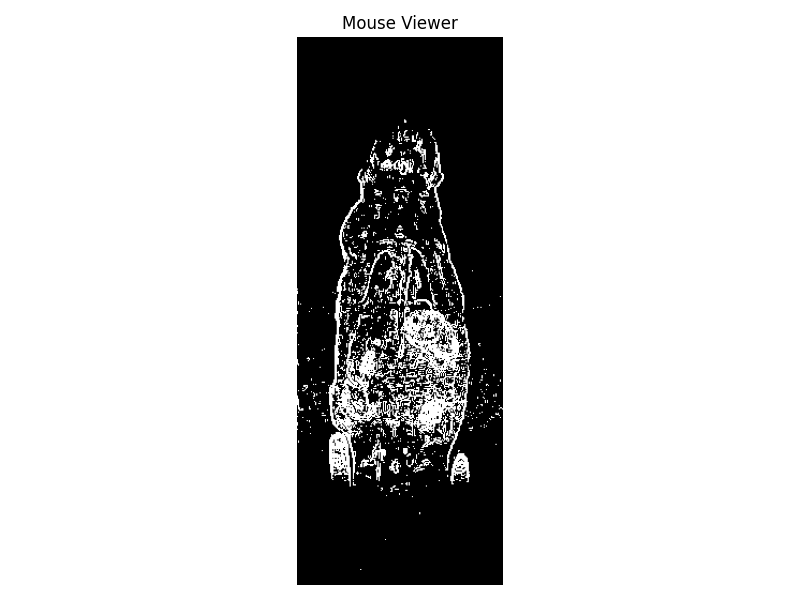

In [29]:
gui.MultiImageDisplay(image_list=[image], title_list=['Mouse Viewer'], figure_size=(8,6))

In [30]:
sitk.WriteImage(image, "mouse_filtered.nii.gz")

In [31]:
#Set limits to x and y for a good view
mouse = sitk.ReadImage("mouse_filtered.nii.gz")
itkwidgets.view(mouse)

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageUS3; pr…

In [39]:
!python dicom2stl/dicom2stl.py -i 1000 -o mouse_filtered.stl mouse_filtered.nii.gz


Temp dir: Not specified, will use system temporary directory
Isovalue =  1000.0
File names:  ['mouse_filtered.nii.gz'] 

Shrink factors:  [1, 2, 1]
(192, 512, 120) -> (192, 256, 120)
     0.011 seconds
Surface extracted
     0 polygons
     0.094 seconds
Surface cleaned
     0 polygons
     0.0 seconds
Small parts cleaned
     0 polygons
     0.045 seconds
Surface smoothed
     0 polygons
     0.004 seconds
Surface reduced
     0 polygons
     0.007 seconds
Writing 0 polygons to mouse_filtered.stl
writeSTL 1
Output mesh: mouse_filtered.stl



2021-07-27 18:58:23.272 (   2.824s) [                ]vtkPolyDataConnectivity:104    ERR| vtkPolyDataConnectivityFilter (000001BF63F2C900): No points!
2021-07-27 18:58:23.314 (   2.865s) [                ]vtkPolyDataConnectivity:104    ERR| vtkPolyDataConnectivityFilter (000001BF63F2C900): No points!
2021-07-27 18:58:23.339 (   2.891s) [                ]vtkWindowedSincPolyData:108    ERR| vtkWindowedSincPolyDataFilter (000001BF6273FB30): No data to smooth!
2021-07-27 18:58:23.362 (   2.914s) [                ]     vtkDecimatePro.cxx:160    ERR| vtkDecimatePro (000001BF65445690): No data to decimate!
2021-07-27 18:58:23.388 (   2.940s) [                ]       vtkSTLWriter.cxx:77     ERR| vtkSTLWriter (000001BF65B5D770): No data to write!


In [33]:
mesh = vtkutils.readMesh('mouse_filtered.stl')
itkwidgets.view(mesh, geometries=[mesh])

Input mesh: mouse_filtered.stl


TraitError: The 'geometries' trait of a Viewer instance must be A data structure for rendering geometry in vtk.js consisting of points, verts (vertices), lines, polys (polygons), triangle strips, point data, and cell data., but a value of [(vtkmodules.vtkCommonDataModel.vtkPolyData)0000014D9028B1C8] <class 'list'> was specified.

In [34]:
!python dicom2stl/dicom2stl.py --help

usage: dicom2stl.py [-h] [--verbose] [--debug] [--output OUTPUT] [--meta META]
                    [--ct] [--clean] [--temp TEMP] [--search SEARCH]
                    [--type {skin,bone,soft_tissue,fat}] [--anisotropic]
                    [--isovalue ISOVALUE] [--double DOUBLE_THRESHOLD]
                    [--largest] [--rotaxis {X,Y,Z}] [--rotangle ROTANGLE]
                    [--smooth SMOOTH] [--reduce REDUCE] [--clean-small SMALL]
                    [--enable {anisotropic,shrink,median,largest,rotation}]
                    [--disable {anisotropic,shrink,median,largest,rotation}]
                    [filenames [filenames ...]]

positional arguments:
  filenames

optional arguments:
  -h, --help            show this help message and exit
  --verbose, -v         Enable verbose messages
  --debug, -D           Enable debugging messages
  --output OUTPUT, -o OUTPUT
                        Output file name (default=result.stl)
  --meta META, -m META  Output metadata file
  --ct    

In [35]:
!python dicom2stl/dicom2stl.py -a -i 90 -t soft_tissue -l --smooth 100 --reduce 0.6 -x 0.1 -o mouse_filtered_2.stl mouse_filtered_2.nii.gz


Temp dir: Not specified, will use system temporary directory
Tissue type:  soft_tissue
Isovalue =  90.0
Error: no valid input given.


In [36]:
mesh = vtkutils.readMesh('mouse_filtered_2.stl')
itkwidgets.view(mesh, geometries=[mesh])

Input mesh: mouse_filtered_2.stl


TraitError: The 'geometries' trait of a Viewer instance must be A data structure for rendering geometry in vtk.js consisting of points, verts (vertices), lines, polys (polygons), triangle strips, point data, and cell data., but a value of [(vtkmodules.vtkCommonDataModel.vtkPolyData)0000014D9028B4C8] <class 'list'> was specified.